In [ ]:
# import sys
# !{sys.executable} -m pip install numpy pandas matplotlib sklearn seaborn

In [1]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

import os
import gensim
import pickle
import zipfile
from urllib import request

import numpy as np
import pandas as pd

import seaborn as sns
from mpl_toolkits import mplot3d

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.python.client import device_lib

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Reshape, Lambda, Add, Concatenate, Multiply, Subtract, Flatten, Dropout

from tensorboard.plugins.hparams import api as hp

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from gensim.models.doc2vec import Doc2Vec

# Resets notebook state
tf.keras.backend.clear_session()

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
%matplotlib inline

In [2]:
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(get_available_devices())

Num GPUs Available:  0
['/device:CPU:0', '/device:XLA_CPU:0']


In [3]:
def download(url, filename, local=True):
    """Download a file if not present"""
    if not local and not os.path.exists(filename):
        print("downloading {}...".format(filename))
        filename, _ = request.urlretrieve(url + filename, filename)

        print("extracting {}...".format(filename))
        with zipfile.ZipFile(filename) as f:
            f.extractall()
            print("extracting {} done".format(filename))

    """directory data"""
    data_path = filename.replace('.zip','')
    if not os.path.exists(data_path):
        if os.path.exists(filename):
            print("extracting {}...".format(filename))
            with zipfile.ZipFile(filename) as f:
                f.extractall()
                print("extracting {} done".format(filename))
        else:
            print('data.zip not found!')

    """directory model for saving model while training"""
    if not os.path.exists('model'):
        os.mkdir('model')
        print("directory model created...")

    return data_path

In [4]:
# download dataset
download(url='https://github.com/kadriansyah/notebook/raw/master/alodokter-recommender/', filename="data.zip", local=True)

'data'

#### Loading in data

In [5]:
n_tag = 5040
tag_max_len = 5

def load_posts():
    df = pd.read_csv('data/ga-articles.csv', sep=',', header=0, encoding="latin-1")
    df.columns = ['post_id', 'title', 'tags']
    return df[['post_id', 'title', 'tags']]

def load_posts_ctr():
    df = pd.read_csv('data/ga-page-clicks.csv', sep=',', header=0, encoding="latin-1")
    df.columns = ['post_id', 'related_post_id', 'ctr']
    return df

def text2seq(text, n_tag):
    """ using tokenizer to encoded the multi-level categorical feature """
    tokenizer = Tokenizer(lower=True, split='|',filters='', num_words=n_tag)
    tokenizer.fit_on_texts(text)
    seq = tokenizer.texts_to_sequences(text)
    seq = pad_sequences(seq, maxlen=tag_max_len,padding='post')
    return seq

#### KMeans

In [6]:
print('load kmeans model...')
kmeans_model = pickle.load(open('model/kmeans.pkl', 'rb'))
clusters = kmeans_model.labels_.tolist()
print('load kmeans model done')

load kmeans model...
load kmeans model done


##### Doc3Vec

In [7]:
print('loading doc2vec model...')
doc2vec_model = Doc2Vec.load('model/alodokter-articles-doc2vec.model')
print('loading doc2vec model done')

loading doc2vec model...
loading doc2vec model done


In [8]:
print('loading pid_post_id...')
pid_post_id = pickle.load(open('model/pid_post_id.pkl', 'rb'))
print('loading pid_post_id...')

post_id_pid = {}
for pid, post_id in pid_post_id.items():
    post_id_pid[post_id] = pid

loading pid_post_id...
loading pid_post_id...


In [9]:
# create dictionary doc-id to cluster-id
clusters_docs = {}
docs_clusters = {(idx, cluster) for idx, cluster in enumerate(clusters)}
for item in docs_clusters:
    if item[1] in clusters_docs.keys():
        clusters_docs[item[1]].append(item[0])
    else:
        clusters_docs[item[1]] = [item[0]]

In [10]:
all_posts = load_posts()
all_posts

,post_id,title,tags
0,710,Gejala Rabies,Kesehatan|rabies
1,715,Gejala Dehidrasi,Kesehatan|Dehidrasi|dehydration
2,716,Gejala Autisme,Kesehatan|autism
3,720,Penyebab Dehidrasi,Kesehatan|Dehidrasi|dehydration
4,724,Penyebab Rabies,Kesehatan
...,...,...,...
6053,1618421,Simak Manfaat Sawi Putih dan Cara Mengolahnya,nutrisi
6054,1632238,Terlalu Banyak Berolahraga Ternyata Tidak Sela...,Hidup Sehat
6055,1621149,Tips Aman Berjemur pada Ibu Hamil,Kesehatan
6056,1677722,"Yuk, Ikuti Tips Menjalani Hidup dengan HIV/AID...",Kesehatan


In [11]:
all_posts['tags'] = text2seq(all_posts.tags.values, n_tag=n_tag).tolist()
all_posts

,post_id,title,tags
0,710,Gejala Rabies,"[1, 530, 0, 0, 0]"
1,715,Gejala Dehidrasi,"[1, 67, 531, 0, 0]"
2,716,Gejala Autisme,"[1, 532, 0, 0, 0]"
3,720,Penyebab Dehidrasi,"[1, 67, 531, 0, 0]"
4,724,Penyebab Rabies,"[1, 0, 0, 0, 0]"
...,...,...,...
6053,1618421,Simak Manfaat Sawi Putih dan Cara Mengolahnya,"[4, 0, 0, 0, 0]"
6054,1632238,Terlalu Banyak Berolahraga Ternyata Tidak Sela...,"[2, 0, 0, 0, 0]"
6055,1621149,Tips Aman Berjemur pada Ibu Hamil,"[1, 0, 0, 0, 0]"
6056,1677722,"Yuk, Ikuti Tips Menjalani Hidup dengan HIV/AID...","[1, 0, 0, 0, 0]"


In [12]:
# lookup dictionary
post_id_title = {}
for index, row in all_posts.iterrows():
    post_id_title[row.post_id] = row.title
len(post_id_title)

6058

In [13]:
# lookup dictionary
post_id_tags = {}
for index, row in all_posts.iterrows():
    post_id_tags[row.post_id] = row.tags
len(post_id_tags)

6058

In [14]:
pids = clusters_docs[0]
post_ids = [pid_post_id[pid] for pid in pids]
len(post_ids)

531

In [15]:
# posts = all_posts[all_posts['post_id'].isin(post_ids)]
# posts
posts = all_posts
posts

,post_id,title,tags
0,710,Gejala Rabies,"[1, 530, 0, 0, 0]"
1,715,Gejala Dehidrasi,"[1, 67, 531, 0, 0]"
2,716,Gejala Autisme,"[1, 532, 0, 0, 0]"
3,720,Penyebab Dehidrasi,"[1, 67, 531, 0, 0]"
4,724,Penyebab Rabies,"[1, 0, 0, 0, 0]"
...,...,...,...
6053,1618421,Simak Manfaat Sawi Putih dan Cara Mengolahnya,"[4, 0, 0, 0, 0]"
6054,1632238,Terlalu Banyak Berolahraga Ternyata Tidak Sela...,"[2, 0, 0, 0, 0]"
6055,1621149,Tips Aman Berjemur pada Ibu Hamil,"[1, 0, 0, 0, 0]"
6056,1677722,"Yuk, Ikuti Tips Menjalani Hidup dengan HIV/AID...","[1, 0, 0, 0, 0]"


In [16]:
posts.sample(20)

,post_id,title,tags
5236,1517243,"Nyeri kepala sebelah kiri, terutama setelah ol...","[87, 318, 0, 0, 0]"
897,25703,Menimbang Risiko Implan Payudara,"[1, 11, 53, 69, 0]"
2385,320691,Zat yang Dapat Terkandung di Dalam Obat Penamb...,"[1, 4, 28, 0, 0]"
3314,621283,Atasi Penyebab Mudah Mengantuk dari Sekarang,"[2, 86, 729, 77, 0]"
270,3993,Penyebab Ejakulasi Dini,"[1, 207, 0, 0, 0]"
1966,194043,mata ikan di telapak tangan,"[442, 0, 0, 0, 0]"
2407,327713,Kapan Bayi Bisa Melihat dengan Jelas?,"[3, 14, 0, 0, 0]"
5660,1682230,Pola Makan untuk Mencegah Kanker Usus Besar,"[2, 249, 4, 0, 0]"
5985,1789712,Cara Menjaga Kesehatan Anda dan Keluarga Selam...,"[2, 92, 35, 865, 0]"
2156,252606,Dermatitis seboroik,"[31, 0, 0, 0, 0]"


In [17]:
posts_ctr = load_posts_ctr()
print("Total Unique Posts: {}".format(posts_ctr.post_id.nunique()))
posts_ctr[['post_id','related_post_id','ctr']]

Total Unique Posts: 5485


,post_id,related_post_id,ctr
0,35162,16176,23
1,35162,1349929,23
2,35162,795410,23
3,35162,1208332,23
4,35162,100640,23
...,...,...,...
41911,993407,85154,23
41912,993407,1163198,23
41913,993407,48394,23
41914,993407,1194586,23


In [18]:
# do some preprocessing to make sure data quality
dataset_clean_1 = posts_ctr.merge(posts, on='post_id', how='left', indicator=True)
dataset_clean_1 = dataset_clean_1[dataset_clean_1._merge == 'both']
dataset_clean_1 = dataset_clean_1.drop(['_merge'], axis=1)
dataset_clean_1

,post_id,related_post_id,ctr,title,tags
0,35162,16176,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]"
1,35162,1349929,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]"
2,35162,795410,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]"
3,35162,1208332,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]"
4,35162,100640,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]"
...,...,...,...,...,...
41911,993407,85154,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]"
41912,993407,1163198,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]"
41913,993407,48394,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]"
41914,993407,1194586,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]"


In [19]:
# lookup dictionary
related_post_id_pid = {}
for _, row in dataset_clean_1.iterrows():
    if row.related_post_id not in related_post_id_pid.keys():
        related_post_id_pid[row.related_post_id] = post_id_pid[row.related_post_id]

In [20]:
def pid_column(row):
    if row['post_id'] in post_id_pid.keys():
        return post_id_pid[row['post_id']]
    else:
        return -1

pid = dataset_clean_1.apply(lambda row: pid_column(row), axis=1)
dataset_clean_1 = dataset_clean_1.assign(pid=pid.values)
dataset_clean_1 = dataset_clean_1[dataset_clean_1['pid'] != -1]
dataset_clean_1

,post_id,related_post_id,ctr,title,tags,pid
0,35162,16176,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246
1,35162,1349929,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246
2,35162,795410,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246
3,35162,1208332,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246
4,35162,100640,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246
...,...,...,...,...,...,...
41911,993407,85154,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096
41912,993407,1163198,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096
41913,993407,48394,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096
41914,993407,1194586,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096


In [21]:
def nid_column(row):
    if row['related_post_id'] in related_post_id_pid.keys():
        return related_post_id_pid[row['related_post_id']]
    else:
        return -1

nid = dataset_clean_1.apply(lambda row: nid_column(row), axis=1)
dataset_clean_1 = dataset_clean_1.assign(nid=nid.values)
dataset_clean_1 = dataset_clean_1[dataset_clean_1['nid'] != -1]
dataset_clean_1

,post_id,related_post_id,ctr,title,tags,pid,nid
0,35162,16176,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,2440
1,35162,1349929,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,522
2,35162,795410,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,141
3,35162,1208332,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,1026
4,35162,100640,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,3822
...,...,...,...,...,...,...,...
41911,993407,85154,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,5253
41912,993407,1163198,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,1007
41913,993407,48394,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,1926
41914,993407,1194586,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,1694


In [22]:
# do some preprocessing to make sure data quality
def related_title_column(row):
    if row['related_post_id'] in post_id_title.keys():
        return post_id_title[row['related_post_id']]
    else:
        return 'NONE'

related_title = dataset_clean_1.apply(lambda row: related_title_column(row), axis=1)
dataset_clean_1 = dataset_clean_1.assign(related_title=related_title.values)

dataset_clean_1 = dataset_clean_1[dataset_clean_1['related_title'] != 'NONE']
dataset_clean_1

,post_id,related_post_id,ctr,title,tags,pid,nid,related_title
0,35162,16176,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,2440,bintik-bintik kecil di seluruh tubuh pada anak
1,35162,1349929,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,522,Antibiotik
2,35162,795410,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,141,Ini Obat Gatal di Selangkangan yang Perlu Dike...
3,35162,1208332,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,1026,Ini Penyebab Dahak Kental Seperti Jelly
4,35162,100640,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,3822,Khasiat Soda Kue Ternyata tidak Hanya Berlaku ...
...,...,...,...,...,...,...,...,...
41911,993407,85154,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,5253,Apakah pengalaman hamil anggur akan mempersuli...
41912,993407,1163198,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,1007,Ini Ciri-ciri Kanker Serviks yang Perlu Anda W...
41913,993407,48394,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,1926,Penyebab Sakit Perut Sebelah Kanan dan Cara Me...
41914,993407,1194586,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,1694,Ketahui Ciri-ciri Hamil di Luar Kandungan Seja...


In [23]:
# do some preprocessing to make sure data quality
def related_tags_column(row):
    return post_id_tags[row['related_post_id']]

related_tags = dataset_clean_1.apply(lambda row: related_tags_column(row), axis=1)
dataset_clean_1 = dataset_clean_1.assign(related_tags=related_tags.values)
dataset_clean_1

,post_id,related_post_id,ctr,title,tags,pid,nid,related_title,related_tags
0,35162,16176,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,2440,bintik-bintik kecil di seluruh tubuh pada anak,"[9, 0, 0, 0, 0]"
1,35162,1349929,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,522,Antibiotik,"[7, 184, 697, 392, 0]"
2,35162,795410,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,141,Ini Obat Gatal di Selangkangan yang Perlu Dike...,"[1, 508, 111, 0, 0]"
3,35162,1208332,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,1026,Ini Penyebab Dahak Kental Seperti Jelly,"[1, 23, 44, 43, 62]"
4,35162,100640,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,3822,Khasiat Soda Kue Ternyata tidak Hanya Berlaku ...,"[11, 252, 12, 809, 120]"
...,...,...,...,...,...,...,...,...,...
41911,993407,85154,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,5253,Apakah pengalaman hamil anggur akan mempersuli...,"[479, 0, 0, 0, 0]"
41912,993407,1163198,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,1007,Ini Ciri-ciri Kanker Serviks yang Perlu Anda W...,"[1, 166, 58, 582, 51]"
41913,993407,48394,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,1926,Penyebab Sakit Perut Sebelah Kanan dan Cara Me...,"[176, 154, 125, 101, 177]"
41914,993407,1194586,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,1694,Ketahui Ciri-ciri Hamil di Luar Kandungan Seja...,"[3, 72, 6, 176, 0]"


#### Final Dataset

In [24]:
dataset = dataset_clean_1
dataset.columns = ['post_id', 'related_post_id', 'page_view', 'title', 'tags', 'pid', 'nid', 'related_title','related_tags']
dataset = dataset[['post_id','pid','title','related_post_id','nid','related_title','related_tags','page_view']]
dataset

,post_id,pid,title,related_post_id,nid,related_title,related_tags,page_view
0,35162,4246,Mengalami gejala alergi di suhu dingin,16176,2440,bintik-bintik kecil di seluruh tubuh pada anak,"[9, 0, 0, 0, 0]",23
1,35162,4246,Mengalami gejala alergi di suhu dingin,1349929,522,Antibiotik,"[7, 184, 697, 392, 0]",23
2,35162,4246,Mengalami gejala alergi di suhu dingin,795410,141,Ini Obat Gatal di Selangkangan yang Perlu Dike...,"[1, 508, 111, 0, 0]",23
3,35162,4246,Mengalami gejala alergi di suhu dingin,1208332,1026,Ini Penyebab Dahak Kental Seperti Jelly,"[1, 23, 44, 43, 62]",23
4,35162,4246,Mengalami gejala alergi di suhu dingin,100640,3822,Khasiat Soda Kue Ternyata tidak Hanya Berlaku ...,"[11, 252, 12, 809, 120]",23
...,...,...,...,...,...,...,...,...
41911,993407,1096,Hamil di Luar Kandungan: Waspadai Penyebab dan...,85154,5253,Apakah pengalaman hamil anggur akan mempersuli...,"[479, 0, 0, 0, 0]",23
41912,993407,1096,Hamil di Luar Kandungan: Waspadai Penyebab dan...,1163198,1007,Ini Ciri-ciri Kanker Serviks yang Perlu Anda W...,"[1, 166, 58, 582, 51]",23
41913,993407,1096,Hamil di Luar Kandungan: Waspadai Penyebab dan...,48394,1926,Penyebab Sakit Perut Sebelah Kanan dan Cara Me...,"[176, 154, 125, 101, 177]",23
41914,993407,1096,Hamil di Luar Kandungan: Waspadai Penyebab dan...,1194586,1694,Ketahui Ciri-ciri Hamil di Luar Kandungan Seja...,"[3, 72, 6, 176, 0]",23


In [25]:
dataset.sample(20)

,post_id,pid,title,related_post_id,nid,related_title,related_tags,page_view
35017,1211731,339,bahaya tingginya leukosit atau sel darah putih...,81055,2641,Cara penyembuhan gonore,"[51, 144, 0, 0, 0]",23
21497,68226,3951,tuberkulosis dan efek samping obat,24630,3185,Sayuran yang boleh dikonsumsi penderita rematik,"[107, 0, 0, 0, 0]",23
20707,1115628,1912,"Tes Urine, Ini yang Harus Anda Ketahui",21063,1246,Infeksi saluran kemih dan tidak haid,"[30, 42, 0, 0, 0]",23
32061,173784,2580,Kenapa setiap penyakit jantung kumat selalu mu...,37971,4630,Apakah penderita gagal jantung yang dirawat di...,"[78, 0, 0, 0, 0]",23
10690,1451242,4525,Menggigil,939054,3325,Obat Sakit Kepala Alami dan Penanganan Sederha...,"[1, 13, 15, 40, 0]",23
12373,1405833,2154,Obat Antihipertensi,166639,3061,"Kelenjar Adrenal, Si Kecil dengan Fungsi Besar","[1, 832, 1192, 604, 68]",23
14648,1002246,532,Hepatitis,486713,3433,Dasar-dasar Prosedur Memanfaatkan Cairan Infus,"[1, 15, 0, 0, 0]",23
36362,910052,4801,Memahami Fungsi Hemoglobin dan Kadar Normalnya...,1574963,3455,Daftar Makanan Penambah Hb Ibu Hamil,"[3, 73, 6, 0, 0]",23
12741,494190,2524,Olanzapine,464744,918,alprazolam,"[31, 0, 0, 0, 0]",23
5893,91882,5273,Cara Mengobati Nanah pada Gusi,631994,5078,Penyebab Gusi Bengkak Bernanah dan Pencegahannya,"[1, 93, 0, 0, 0]",159


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a3ac9b790>],
      dtype=object)

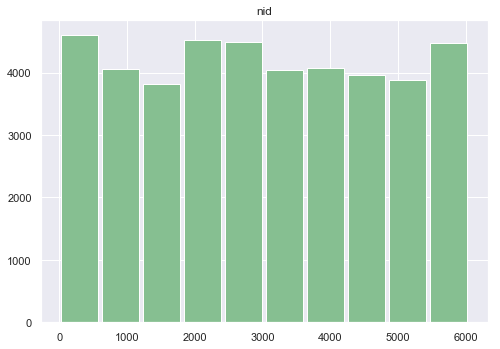

In [26]:
# Histogram
dataset.hist(column='nid', grid=True, figsize=(8,20), layout=(3,1), sharex=True, color='#86bf91', zorder=2, rwidth=0.9)

In [27]:
num_pid = len(dataset.pid.unique())
num_nid = len(dataset.nid.unique())
print('There are {} unique pid and {} unique nid in this dataset '.format(num_pid, num_nid))

There are 5485 unique pid and 5520 unique nid in this dataset 


In [28]:
pid_max = dataset.pid.max()
nid_max = dataset.nid.max()
print('There are {} distinct posts in posts-ctr and the max of pid is {}'.format(num_pid, pid_max))
print('There are {} distinct posts in posts-ctr and the max of nid is {}'.format(num_nid, nid_max))

There are 5485 distinct posts in posts-ctr and the max of pid is 6057
There are 5520 distinct posts in posts-ctr and the max of nid is 6057


#### Creating Model

##### Define Input Layers

In [29]:
def define_input_layers():
    # single level categorical features
    pid_input = Input((1,), name='input_pid')
    nid_input = Input((1,), name='input_nid')
    cat_sl_inputs = [pid_input, nid_input]
    
    # multi level categorical features (with tag_max_len tags at most)
    tag_input = Input((tag_max_len,), name='input_tag')
    cat_ml_inputs = [tag_input]
    
    inputs = cat_sl_inputs + cat_ml_inputs
    return inputs

In [30]:
def Tensor_Mean_Pooling(name='mean_pooling', keepdims=False):
    return Lambda(lambda x: K.mean(x, axis=1, keepdims=keepdims), name=name)

def fm_1d(inputs, n_pid, n_nid, n_tag):
    pid_input, nid_input, tag_input = inputs
    
    # all tensors are reshape to (None, 1)
    cat_sl_embed_1d = [Embedding(n_pid + 1, 1, name='cat_embed_1d_pid')(pid_input),
                       Embedding(n_nid + 1, 1, name='cat_embed_1d_nid')(nid_input)]
    cat_ml_embed_1d = [Embedding(n_tag + 1, 1, mask_zero=True, name='cat_embed_1d_term')(tag_input)]
    
    cat_sl_embed_1d = [Reshape((1,))(i) for i in cat_sl_embed_1d]
    cat_ml_embed_1d = [Tensor_Mean_Pooling(name = 'embed_1d_mean')(i) for i in cat_ml_embed_1d]
    
    # add all tensors
    y_fm_1d = Add(name='fm_1d_output')(cat_sl_embed_1d + cat_ml_embed_1d)
    
    return y_fm_1d

In [31]:
def fm_2d(inputs, n_pid, n_nid, n_tag, k):
    pid_input, nid_input, tag_input = inputs
    
    cat_sl_embed_2d = [Embedding(n_pid + 1, k, name='cat_embed_2d_pid')(pid_input),
                       Embedding(n_nid + 1, k, name='cat_embed_2d_nid')(nid_input)] # shape (None, 1, k)
    
    cat_ml_embed_2d = [Embedding(n_tag + 1, k, name = 'cat_embed_2d_tag')(tag_input)] # shape (None, 3, k)
    cat_ml_embed_2d = [Tensor_Mean_Pooling(name = 'cat_embed_2d_tag_mean', keepdims=True)(i) for i in cat_ml_embed_2d] # shape (None, 1, k)
    
    # concatenate all 2d embed layers => (None, 4, k)
    embed_2d = Concatenate(axis=1, name='concat_embed_2d')(cat_sl_embed_2d + cat_ml_embed_2d)
    
    # calcuate the interactions by simplication: sum of (x1*x2) = sum of (0.5*[(xi)^2 - (xi^2)])
    tensor_sum = Lambda(lambda x: K.sum(x, axis=1), name='sum_of_tensors')
    tensor_square = Lambda(lambda x: K.square(x), name='square_of_tensors')
    
    sum_of_embed = tensor_sum(embed_2d)
    square_of_embed = tensor_square(embed_2d)
    
    square_of_sum = Multiply()([sum_of_embed, sum_of_embed])
    sum_of_square = tensor_sum(square_of_embed)
    
    sub = Subtract()([square_of_sum, sum_of_square])
    sub = Lambda(lambda x: x*0.5)(sub)
    y_fm_2d = Reshape((1,), name='fm_2d_output')(tensor_sum(sub))
    
    return y_fm_2d, embed_2d

In [32]:
def deep_part(embed_2d, dnn_dim, dnn_dr):
    # flat embed layers from 3D to 2D tensors
    y_dnn = Flatten(name = 'flat_embed_2d')(embed_2d)
    for h in dnn_dim:
        y_dnn = Dropout(dnn_dr)(y_dnn)
        y_dnn = Dense(h, activation='relu')(y_dnn)
    y_dnn = Dense(1, activation='relu', name = 'deep_output')(y_dnn)
    
    return y_dnn

In [33]:
def deep_fm_model(n_pid, n_nid, n_tag, k, dnn_dim, dnn_dr):
    inputs = define_input_layers()
    
    y_fm_1d = fm_1d(inputs, n_pid, n_nid, n_tag)
    y_fm_2d, embed_2d = fm_2d(inputs, n_pid, n_nid, n_tag, k)
    y_dnn = deep_part(embed_2d, dnn_dim, dnn_dr)
    
    # combinded deep and fm parts
    y = Concatenate()([y_fm_1d, y_fm_2d, y_dnn])
    y = Dense(1, name='deepfm_output')(y)
    
    fm_model_1d = Model(inputs, y_fm_1d)
    fm_model_2d = Model(inputs, y_fm_2d)
    deep_model = Model(inputs, y_dnn)
    deep_fm_model = Model(inputs, y)
    
    return fm_model_1d, fm_model_2d, deep_model, deep_fm_model

In [34]:
params = {
    'n_pid': pid_max,
    'n_nid': nid_max,
    'n_tag': n_tag,
    'k': 20,
    'dnn_dim':[64,64],
    'dnn_dr': 0.5
}
fm_model_1d, fm_model_2d, deep_model, deep_fm_model = deep_fm_model(**params)

In [35]:
from sklearn.preprocessing import StandardScaler

def df2xy(data):
    x = [data.pid.values,
         data.nid.values,
         np.concatenate(data.related_tags.values).reshape(-1, tag_max_len)]
    
    scaler = StandardScaler()
    standardized = scaler.fit_transform(data.page_view.values.reshape(-1, 1))
    y = standardized.flatten()
    return x,y

# def df2xy(data):
#     x = [data.pid.values,
#          data.nid.values,
#          np.concatenate(data.related_tags.values).reshape(-1, tag_max_len)]
#     y = data.page_view.values
#     return x,y

train_data, valid_data = train_test_split(dataset, test_size=0.5, shuffle=True, random_state=99)
train_x, train_y = df2xy(train_data)
valid_x, valid_y = df2xy(valid_data)

In [36]:
training = True
if not training and os.path.exists('model/deepfm_weights-ctr.h5'):
    deep_fm_model = deep_fm_model.load_weights('model/deepfm_weights-ctr.h5')
else:
    # train  model
    with tf.device('/device:CPU:0'):
        deep_fm_model.compile(loss='MSE', optimizer=tf.keras.optimizers.Adam(0.001))
        early_stop = EarlyStopping(monitor='val_loss', patience=3)
        model_ckp = ModelCheckpoint(filepath='model/deepfm_weights-ctr.h5', monitor='val_loss', save_weights_only=True, save_best_only=True)
        callbacks = [model_ckp, early_stop]
        train_history = deep_fm_model.fit(train_x, train_y, epochs=1000, batch_size=4096, validation_split=0.1, callbacks=callbacks)

Train on 18862 samples, validate on 2096 samples
Epoch 1/1000
18862/18862 [==============================] - 1s 64us/sample - loss: 0.6907 - val_loss: 3.7800
Epoch 2/1000
18862/18862 [==============================] - 0s 4us/sample - loss: 0.6895 - val_loss: 3.7793
Epoch 3/1000
18862/18862 [==============================] - 0s 5us/sample - loss: 0.6884 - val_loss: 3.7784
Epoch 4/1000
18862/18862 [==============================] - 0s 5us/sample - loss: 0.6872 - val_loss: 3.7775
Epoch 5/1000
18862/18862 [==============================] - 0s 5us/sample - loss: 0.6860 - val_loss: 3.7765
Epoch 6/1000
18862/18862 [==============================] - 0s 5us/sample - loss: 0.6846 - val_loss: 3.7755
Epoch 7/1000
18862/18862 [==============================] - 0s 5us/sample - loss: 0.6832 - val_loss: 3.7744
Epoch 8/1000
18862/18862 [==============================] - 0s 5us/sample - loss: 0.6816 - val_loss: 3.7732
Epoch 9/1000
18862/18862 [==============================] - 0s 5us/sample - loss: 0.67

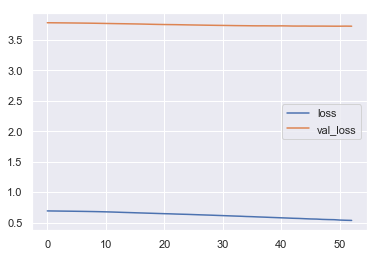

In [37]:
pd.DataFrame(train_history.history).plot()

In [38]:
weights = deep_fm_model.get_weights()
fm_1_weight, fm_2d_weigth, deep_weight = weights[-2]
print("""
contribution of different part of model
    weight of 1st order fm: %5.3f
    weight of 2nd order fm: %5.3f
    weight of dnn part: %5.3f
""" % (fm_1_weight, fm_2d_weigth, deep_weight))


contribution of different part of model
    weight of 1st order fm: -0.746
    weight of 2nd order fm: 0.875
    weight of dnn part: -0.257



##### Model Evaluation

In [39]:
with tf.device('/device:CPU:0'):
    deep_fm_model.evaluate(valid_x, valid_y)

20958/20958 [==============================] - 0s 23us/sample - loss: 0.9989


#### Recommendations

In [40]:
posts.sample(20)

,post_id,title,tags
4102,948319,Agoraphobia,"[1, 5, 1467, 0, 0]"
364,4656,Gejala Gangguan Bipolar,"[1, 241, 61, 0, 0]"
2105,235469,Bijak Memilih Minyak untuk Memasak Demi Kesehatan,"[155, 503, 433, 54, 37]"
2749,449965,6 Kekhawatiran Ibu Hamil Trimester Ketiga,"[3, 6, 254, 0, 0]"
4304,1075798,Promag,"[7, 462, 70, 0, 0]"
1137,63187,Cara Mengatasi Perut Kembung Saat Hamil,"[3, 6, 167, 145, 89]"
5799,1745415,Kenali Lebih Jauh Seputar Bintik Kuning di Mata,"[1, 25, 0, 0, 0]"
4593,1186317,Memahami Linea Nigra atau Garis Memanjang pada...,"[3, 11, 6, 12, 0]"
5825,1752435,Sederet Manfaat Memeluk Anak,"[3, 9, 8, 0, 0]"
5553,1640132,Simak Manfaat Air Beras untuk Wajah dan Cara M...,"[2, 11, 12, 0, 0]"


##### See on Rating Data

In [44]:
post_id = 4656
dataset[dataset['post_id'] == post_id]

,post_id,pid,title,related_post_id,nid,related_title,related_tags,page_view
6418,4656,3755,Gejala Gangguan Bipolar,4658,6046,Penyebab Gangguan Bipolar,"[1, 241, 61, 0, 0]",295
6419,4656,3755,Gejala Gangguan Bipolar,4661,2441,Diagnosis Gangguan Bipolar,"[1, 241, 61, 0, 0]",113
6420,4656,3755,Gejala Gangguan Bipolar,78516,890,Pengertian gangguan bipolar,"[241, 0, 0, 0, 0]",68
24014,4656,3755,Gejala Gangguan Bipolar,476047,922,Kenali Penyebab dan Cara Mengatasi Mood Swing,"[1, 241, 34, 0, 0]",45
24015,4656,3755,Gejala Gangguan Bipolar,115198,4916,Penderita Gangguan Delusi Suka Meyakini yang A...,"[1, 34, 311, 192, 0]",45
40908,4656,3755,Gejala Gangguan Bipolar,509394,4158,Kenali Tiga Jenis Gangguan Kecemasan dan Gejal...,"[1, 893, 268, 34, 0]",23
40909,4656,3755,Gejala Gangguan Bipolar,660991,2023,Apakah psikosis berbahaya?,"[34, 0, 0, 0, 0]",23


##### Find Similarity based on Document to Vector

In [45]:
pid = post_id_pid[post_id]
sims = doc2vec_model.docvecs.most_similar([doc2vec_model[pid]], topn=20)
nids = [nid for nid,_ in sims]
most_similars = dataset[dataset['nid'].isin(nids)].drop_duplicates(subset='nid', keep='last')
most_similars[['related_post_id','nid','related_title','page_view']]

,related_post_id,nid,related_title,page_view
936,1162857,5663,Akathisia: Efek Samping Obat Antispikotik yang...,23
947,1552491,1776,Perbedaan Bipolar dengan Moody,23
6168,4753,1806,Penyebab Depresi,227
9166,1121,2622,Gejala Stroke,91
12712,2998,4762,Penyebab OCD (Obsessive Compulsive Disorder),23
25680,1787922,4565,Halusinasi,45
26448,1671113,2124,Tanda Kamu Mengalami Gangguan Jiwa,45
28284,4751,1042,Gejala Depresi,23
31643,4757,5979,Pengobatan Depresi,23
32455,1412796,2953,Percobaan Bunuh Diri,23


##### Scoring based on Page Click Collaborative Filtering

In [46]:
# Creating dataset for making recommendations
nids = most_similars.nid.values
pred = [np.array([pid for i in range(len(nids))]),
        nids,
        np.array([dataset[dataset.nid == nid].related_tags.values[0] for nid in nids])]
predictions = deep_fm_model.predict(pred)
predictions = np.array([a[0] for a in predictions])
recommended_ids = (-predictions).argsort()[:20]

recommendations = pd.DataFrame()
nids = [nids[idx] for idx in recommended_ids]
for nid in nids:
    recommendations = recommendations.append(dataset[dataset['nid'] == nid])
recommendations[['related_post_id','nid','related_title','page_view']].drop_duplicates(subset='nid', keep='last')

,related_post_id,nid,related_title,page_view
6168,4753,1806,Penyebab Depresi,227
32811,451756,5779,"Serangan Panik Beda dengan Serangan Jantung, I...",23
9166,1121,2622,Gejala Stroke,91
12712,2998,4762,Penyebab OCD (Obsessive Compulsive Disorder),23
32976,4656,3755,Gejala Gangguan Bipolar,23
32455,1412796,2953,Percobaan Bunuh Diri,23
31643,4757,5979,Pengobatan Depresi,23
26448,1671113,2124,Tanda Kamu Mengalami Gangguan Jiwa,45
35382,1063597,3235,Kepribadian Ganda,23
947,1552491,1776,Perbedaan Bipolar dengan Moody,23
